<a href="https://colab.research.google.com/github/pejmanS21/Street_Segmentation/blob/main/street_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
pip install -qU gdown
echo https://drive.google.com/file/d/1-S-xVyktQu67rRHKKsUXqMb1G8t1gLTM/view?usp=sharing
gdown --id 1-S-xVyktQu67rRHKKsUXqMb1G8t1gLTM

https://drive.google.com/file/d/1-S-xVyktQu67rRHKKsUXqMb1G8t1gLTM/view?usp=sharing


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1-S-xVyktQu67rRHKKsUXqMb1G8t1gLTM
To: /content/Udacity_Unet.pth
100%|██████████| 124M/124M [00:00<00:00, 131MB/s]


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as T
from torchsummary import summary
# import albumentations as A
# from albumentations.pytorch import ToTensor

In [ ]:
h, w = 160, 240
batch_size = 8
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

transformer = T.Compose([
            T.Resize((h, w)),
            T.ToTensor(),
            T.Normalize(*stats),
])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False), 
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.conv(x)


class TConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TConvLayer, self).__init__()
        self.tconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
    
    def forward(self, x):
        return self.tconv(x)


class UNet(nn.Module):
    def __init__(self, out_channels=23, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv1 = ConvLayer(3,features[0])
        self.conv2 = ConvLayer(features[0], features[1])
        self.conv3 = ConvLayer(features[1], features[2])
        self.conv4 = ConvLayer(features[2], features[3])
        self.conv5 = ConvLayer(features[3] * 2,features[3])
        self.conv6 = ConvLayer(features[3], features[2])
        self.conv7 = ConvLayer(features[2], features[1])
        self.conv8 = ConvLayer(features[1], features[0])        
        
        self.tconv1 = TConvLayer(features[-1] * 2, features[-1])
        self.tconv2 = TConvLayer(features[-1], features[-2])
        self.tconv3 = TConvLayer(features[-2], features[-3])
        self.tconv4 = TConvLayer(features[-3], features[-4])        
        
        self.bottleneck = ConvLayer(features[3], features[3] * 2)
        self.final_layer = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        x = self.conv1(x)
        
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        
        x = self.conv5(x)
        x = self.tconv2(x)
        
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        
        return x
    
    def _summary_(self, input_size=(3, 160, 240)):
        return summary(self, input_size)

In [ ]:
model = UNet().to(device)
model._summary_()

model.eval()
model.load_state_dict(torch.load('/content/Udacity_Unet.pth', map_location=device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 240]           1,728
       BatchNorm2d-2         [-1, 64, 160, 240]             128
              ReLU-3         [-1, 64, 160, 240]               0
            Conv2d-4         [-1, 64, 160, 240]          36,864
       BatchNorm2d-5         [-1, 64, 160, 240]             128
              ReLU-6         [-1, 64, 160, 240]               0
         ConvLayer-7         [-1, 64, 160, 240]               0
         MaxPool2d-8          [-1, 64, 80, 120]               0
            Conv2d-9         [-1, 128, 80, 120]          73,728
      BatchNorm2d-10         [-1, 128, 80, 120]             256
             ReLU-11         [-1, 128, 80, 120]               0
           Conv2d-12         [-1, 128, 80, 120]         147,456
      BatchNorm2d-13         [-1, 128, 80, 120]             256
             ReLU-14         [-1, 128, 

<All keys matched successfully>

In [ ]:
def denormal(pil_image, img_stats=stats):
    """denormalize  pil image
    Args:
        pil_image (PIL Image)
        img_stats (Tuple, optional). Defaults to ((0.5, ), (0.5, )).
    Returns:
        pil_image (PIL Image)
    """
    return pil_image * img_stats[1][0] + img_stats[0][0]

In [ ]:
def get_pred(model, image, device):
    if len(image) == 3:
        image = image.unsqueeze(0)
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(image.to(device))),axis=1).cpu()
    fig, ax = plt.subplots(1, 2, figsize=(18, 18))
    ax[0].imshow(denormal(image[0]).permute(1, 2, 0))
    ax[1].imshow(preds[0].cpu())
    
    ax[0].set_title('Image')
    ax[1].set_title('Prediction')
    
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

In [ ]:
%%bash
gdown --id 1bzObE7EBmEzt3H8Sz_E4PSJGsNHwMaZ7
gdown --id 15thRwoqsBJZE0WqlL8gJoBme7o2bymCA
gdown --id 13JYBJcW67WyLvmF8Qr8cdm3QC8b8xia6

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1bzObE7EBmEzt3H8Sz_E4PSJGsNHwMaZ7
To: /content/test.png
100%|██████████| 439k/439k [00:00<00:00, 83.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=15thRwoqsBJZE0WqlL8gJoBme7o2bymCA
To: /content/test2.png
100%|██████████| 446k/446k [00:00<00:00, 63.1MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloadi

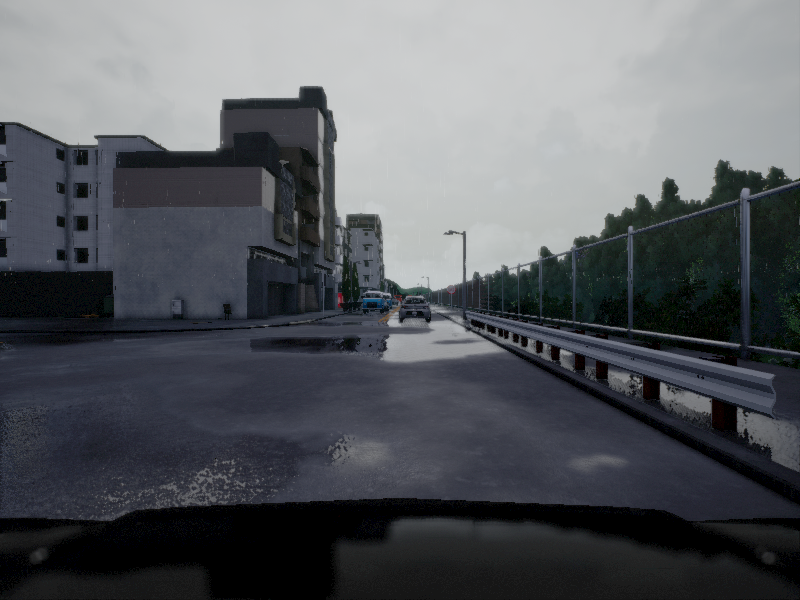

In [ ]:
# path = '/content/test.png'
path = '/content/test2.png'
# path = '/content/test3.png'

image = Image.open(path)
image

In [ ]:
image = transformer(image)
image.size()

torch.Size([3, 160, 240])

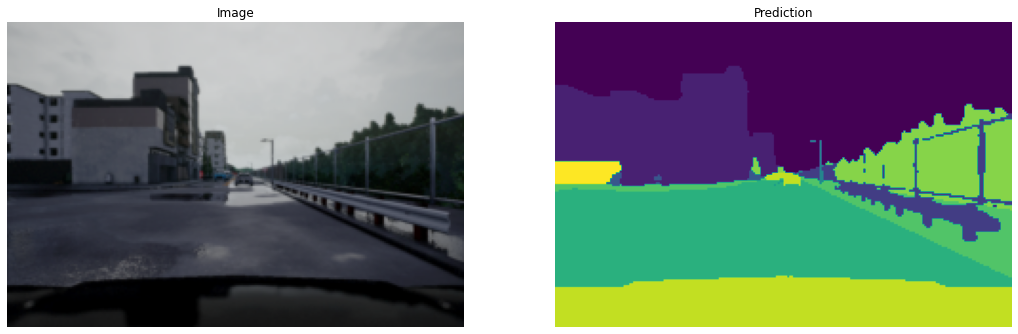

In [ ]:
get_pred(model, image, device)